<a href="https://colab.research.google.com/github/Jae2Wook/Machine-Learning-Class/blob/main/Group_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
len(bikes)

17379

**Jae (season 4: Fall)**

In [ ]:
 year = bikes["dteday"].str.split("/").str.get(2).str.strip()
 year

0        11
1        11
2        11
3        11
4        11
         ..
17374    12
17375    12
17376    12
17377    12
17378    12
Name: dteday, Length: 17379, dtype: object

In [ ]:
bikes["month"] = bikes["dteday"].str.split("/").str.get(0)
bikes["month"] = pd.to_numeric(bikes["month"])
bikes["target"] = bikes["casual"] + bikes["registered"]
#bikes["day"] = bikes["dteday"].str.split("/").str.get(1).str.strip()
#bikes["day"] = pd.to_numeric(bikes["day"])

# help me to get the easier way.
# divided that is almost over 10,000 bikes in total in each hour
#maps = {23:0, 0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1, 17:1, 18:1, 19:1, 20:1, 21:1, 22:1}
#bikes["busy"] = bikes["hr"].map(maps)

#bikes = pd.get_dummies(bikes, columns = ["weathersit"])

bikes.dteday = pd.to_datetime(bikes.dteday)

bike2 = bikes

# bikes[(bikes["holiday"] == 1) & (bikes["workingday"] == 1)]

#bikes = bikes[bikes['season'] ==1]
#bikes

# season, hr, workingday,weathersit, windspeed, temp_c, total, month
# huber, learning_rate: 0.01
# Rachalle: season: 1,2, Drew: 3, Jae:4 

bikes.head(2)

dteday  season  hr  holiday  ...  casual  registered  month  target
0 2011-01-01       1   0        0  ...       3          13      1      16
1 2011-01-01       1   1        0  ...       8          32      1      40

[2 rows x 14 columns]

Data analysis to find optimal features

In [ ]:
#a = pd.DataFrame(bikes.groupby("dteday").target.sum()).reset_index().rename(columns = {"target":"real_target"})
#a

In [ ]:
#bike = pd.merge(bikes, a, how = "left", left_on = "dteday", right_on = "dteday")
#bikes.head()

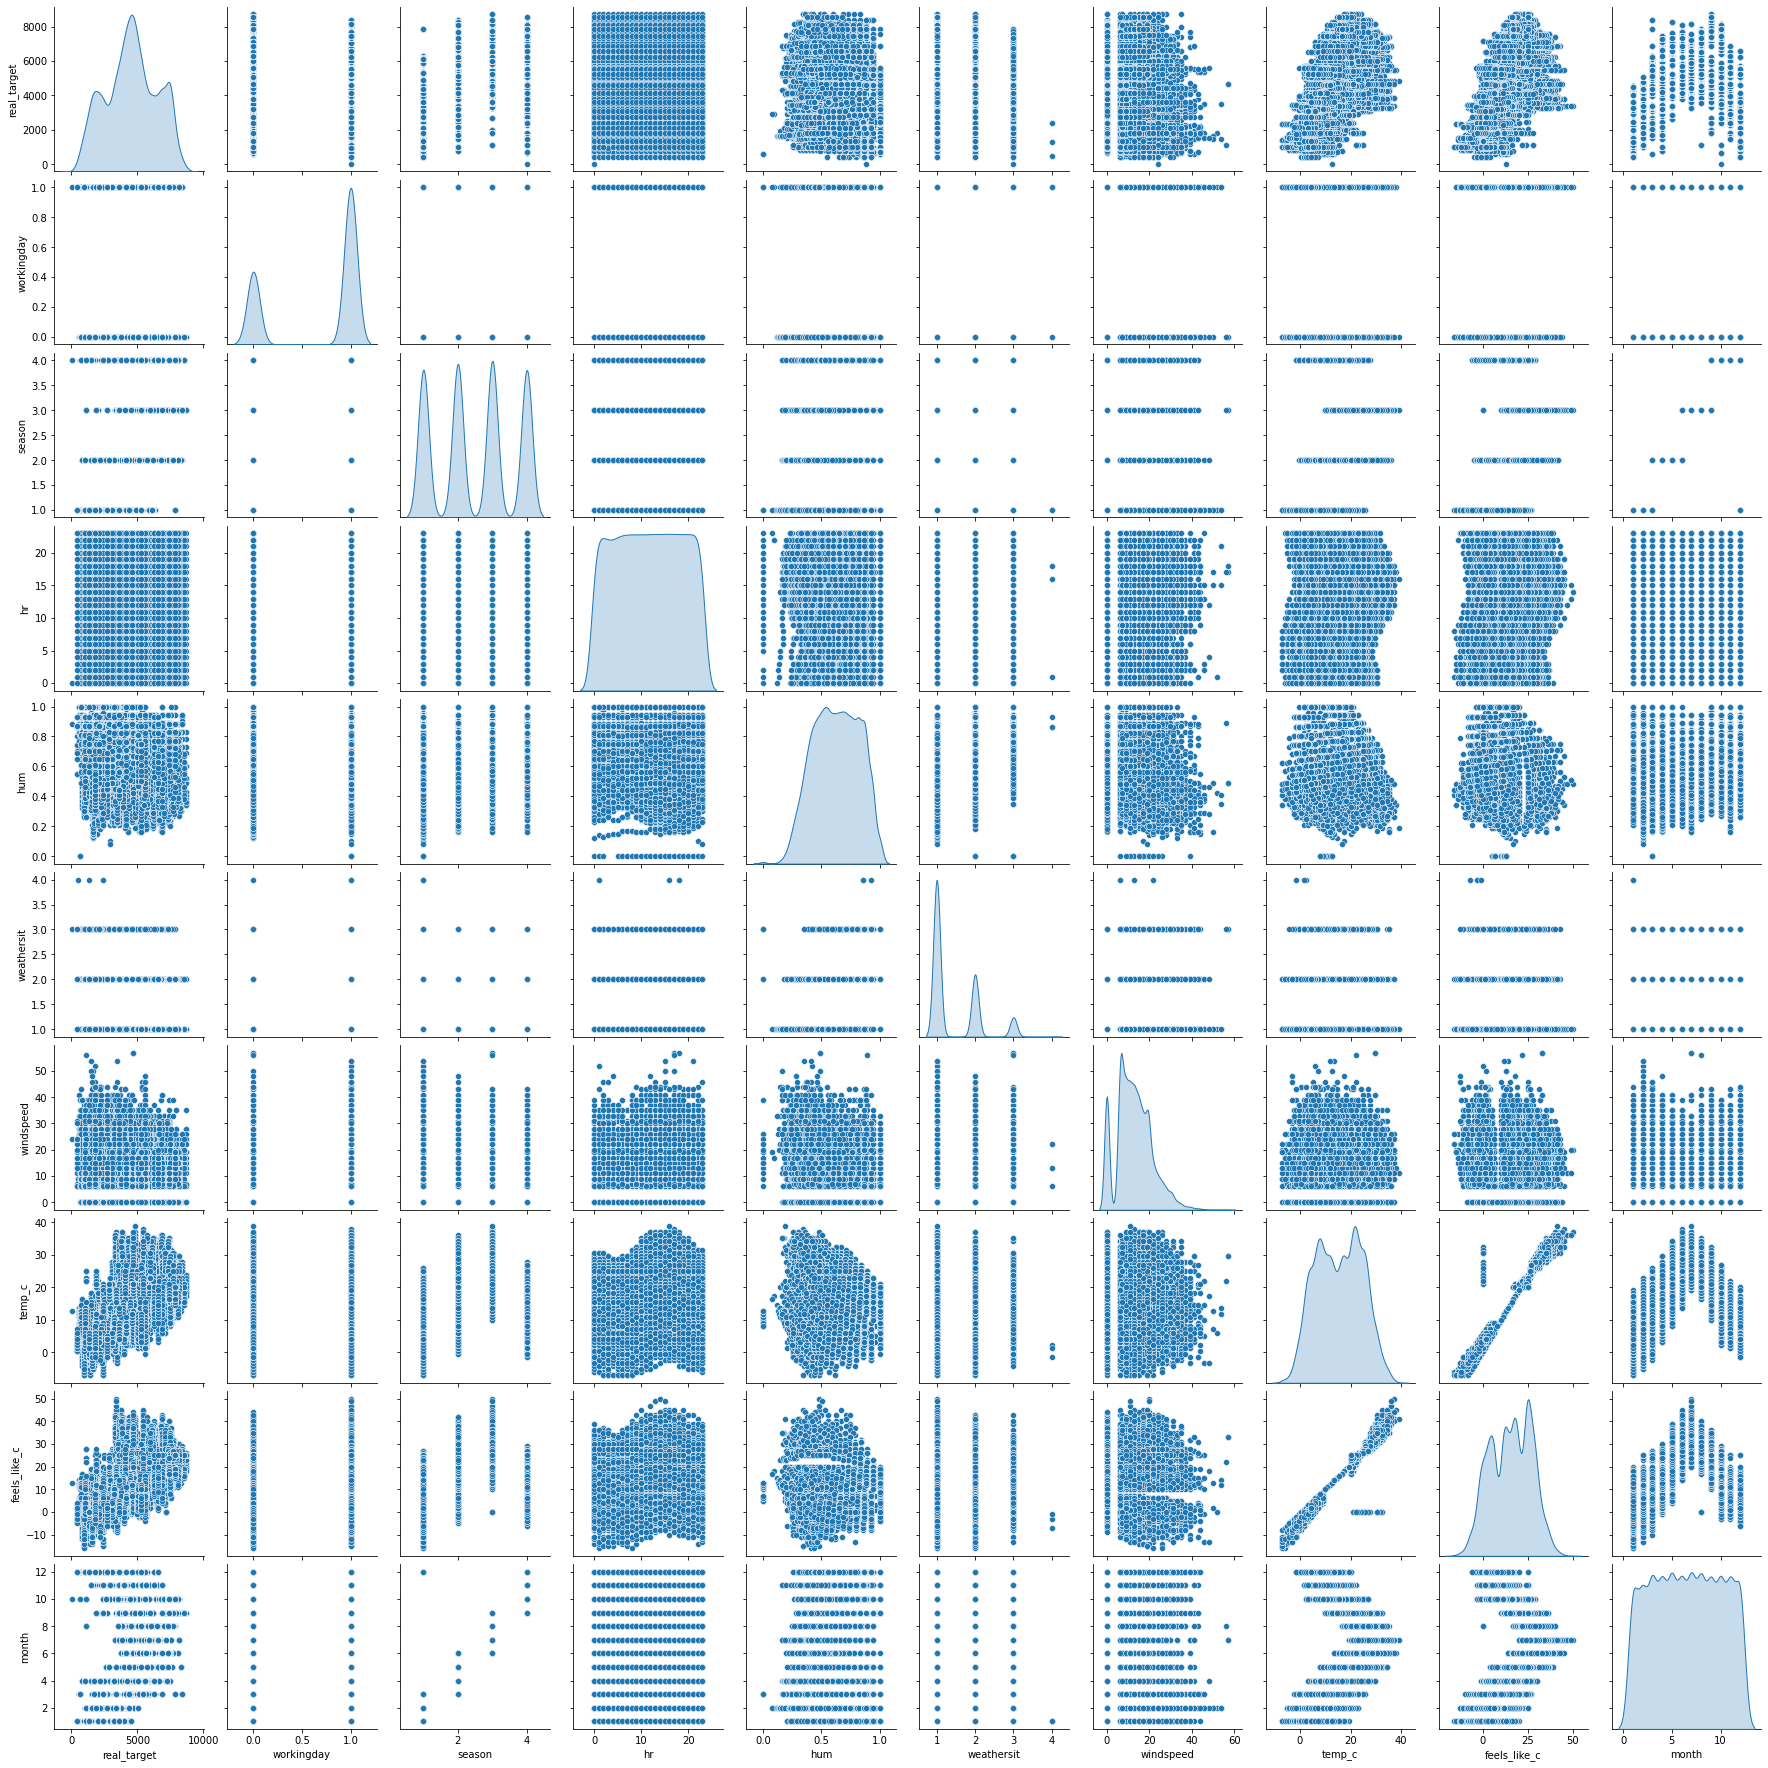

In [ ]:
sns.pairplot(bike[["real_target",'workingday', 'season', "hr", "hum", 'weathersit', 'windspeed', 'temp_c', "feels_like_c",'month']], diag_kind='kde')

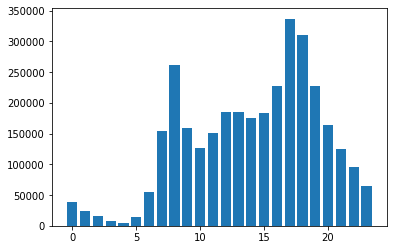

In [ ]:
plt.bar(bikes.hr.unique(), bikes.groupby("hr").target.sum())
plt.show()

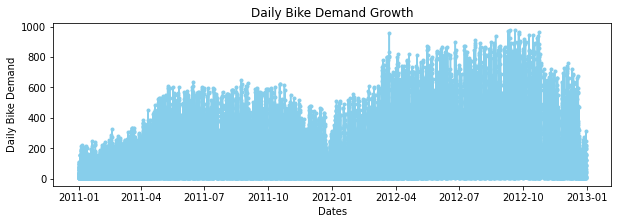

In [ ]:
plt.figure(figsize = (10, 3))
plt.plot(bikes["dteday"], bikes["target"],".-", c = "skyblue")
plt.title("Daily Bike Demand Growth")
plt.xlabel("Dates")
plt.ylabel("Daily Bike Demand")
plt.show()

Model building

In [ ]:
bikes = bikes.drop(["holiday","dteday", "feels_like_c", "casual", "registered"], axis = 1).copy()
bikes = bikes[bikes["season"] == 4]

train_dataset = bikes.sample(frac=0.8, random_state=42)
test_dataset = bikes.drop(train_dataset.index)

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([norm,
                            layers.Dense(512, activation = "relu"),#, kernel_regularizer = regularizers.l2(0.0001)),
                            layers.Dense(512, activation = "relu"),#, kernel_regularizer = regularizers.l2(0.0001)),
                            layers.Dense(1)])
  model.compile(loss = tf.keras.losses.Huber(delta = 1), optimizer = tf.optimizers.Adam(learning_rate = 0.01), metrics = ['mae', 'mse'])
  return model

dnn_bike_model = build_and_compile_model(normalizer)
dnn_bike_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_12 (Normalizat (None, 8)                 17        
_________________________________________________________________
dense_92 (Dense)             (None, 512)               4608      
_________________________________________________________________
dense_93 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 513       
Total params: 267,794
Trainable params: 267,777
Non-trainable params: 17
_________________________________________________________________


In [ ]:
example_batch = train_features[:10]
example_result = dnn_bike_model.predict(example_batch)
example_result

array([[-0.11486693],
       [-0.3223997 ],
       [-0.21339627],
       [-0.17430569],
       [-0.19495782],
       [-0.08516884],
       [-0.15262854],
       [-0.02841006],
       [-0.19457647],
       [-0.35321292]], dtype=float32)

In [ ]:
# display training progress by printing a single dot for each completed epoch

class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print("")
    print(".", end = "")

Epochs = 100

history = dnn_bike_model.fit(
    train_features, train_labels, validation_split = 0.2,
    epochs = Epochs, verbose = 0, callbacks = [PrintDot()]
)


....................................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss        mae          mse   val_loss    val_mae      val_mse  epoch
95  32.844822  33.335003  3019.789062  50.602604  51.090710  6212.862793     95
96  33.138691  33.627201  3040.991455  49.617626  50.108402  6131.660645     96
97  33.678993  34.168762  3153.681641  50.247627  50.739784  6616.654297     97
98  32.574440  33.064163  3005.148193  51.001381  51.495018  7060.770508     98
99  32.338676  32.829685  2981.442871  51.134560  51.625553  6666.362793     99

In [ ]:
loss, mae, mse = dnn_bike_model.evaluate(test_features, test_labels, verbose = 0)

print(f"Testing set Mean Absolute Error: {mae} bikes")

Testing set Mean Absolute Error: 53.693931579589844 bikes


See predictions

In [ ]:
bike1 = bike.drop(["target"], axis = 1).copy()
bike1 = bike1[bike1["season"] == 4]

In [ ]:
bike2.head(2)

dteday  season  hr  holiday  ...  casual  registered  month  target
0 2011-01-01       1   0        0  ...       3          13      1      16
1 2011-01-01       1   1        0  ...       8          32      1      40

[2 rows x 14 columns]

In [ ]:
y_pred = dnn_bike_model.predict(bike1)
bike1["predicted"] = np.round(y_pred, 0)
bike1["predicted"] = bike1["predicted"].astype(int)


bike1[["season", "month", "hr", "workingday", "weathersit", "windspeed", "hum", "temp_c", "predicted"]].head(2)

season  month  hr  workingday  ...  windspeed   hum  temp_c  predicted
6250       4      9   0           1  ...          6  0.94   21.14         46
6251       4      9   1           1  ...          0  1.00   20.20         22

[2 rows x 9 columns]

In [ ]:
bike2.head(2)

dteday  season  hr  holiday  ...  casual  registered  month  target
0 2011-01-01       1   0        0  ...       3          13      1      16
1 2011-01-01       1   1        0  ...       8          32      1      40

[2 rows x 14 columns]

comparing with prediction and true

In [ ]:
all_mer = pd.merge(bike2, bike1["predicted"], left_index = True, right_index = True)
all_mer.head(2)

dteday  season  hr  holiday  ...  registered  month  target  predicted
6250 2011-09-23       4   0        0  ...          41      9      52         46
6251 2011-09-23       4   1        0  ...          29      9      31         22

[2 rows x 15 columns]

In [ ]:
total = all_mer.groupby("dteday").target.sum()
predict = all_mer.groupby("dteday").predicted.sum()
a_day_prediction = pd.merge(total, predict, how = "left", left_on = "dteday", right_on = "dteday")
a_day_prediction["error_size"] =  a_day_prediction["predicted"] - a_day_prediction["target"]
a_day_prediction[142:147]

target  predicted  error_size
dteday                                   
2012-11-15    5445       5366         -79
2012-11-16    5698       5766          68
2012-11-17    5629       4810        -819
2012-11-18    4669       4500        -169
2012-11-19    5499       4878        -621

In [ ]:
average_error_size = sum(abs(a_day_prediction["error_size"]))/len(a_day_prediction)
average_error_size

614.6404494382023

In [ ]:
max_error = abs(a_day_prediction["error_size"]).max()
max_error

2447

In [ ]:
min_error = abs(a_day_prediction["error_size"]).min()
min_error

1

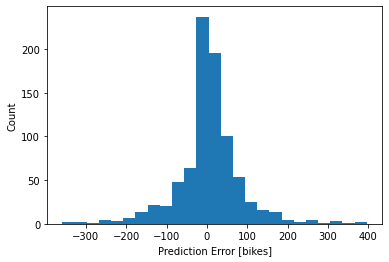

In [ ]:
test_predictions = dnn_bike_model.predict(test_features).flatten()

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [bikes]")
_=plt.ylabel("Count")

(-47.300000000000004, 1015.3, -48.956693172454834, 1112.1342844963074)

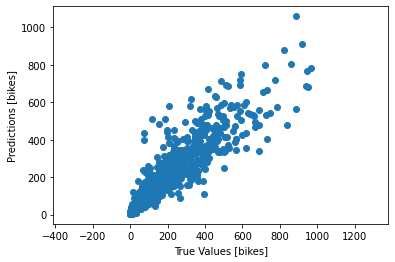

In [ ]:
test_predictions = dnn_bike_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [bikes]")
plt.ylabel("Predictions [bikes]")
plt.xlim([0,test_labels.max()])
plt.ylim([0,test_predictions.max()])
plt.axis('equal')

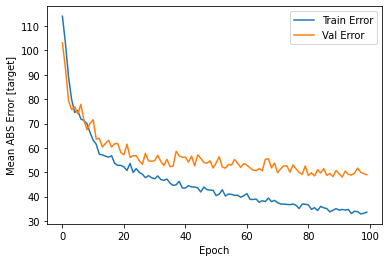

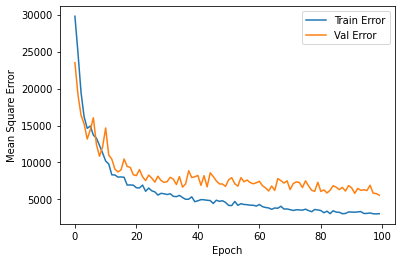

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist["epoch"] = history.epoch

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean ABS Error [target]")
  plt.plot(hist['epoch'], hist['mae'], label = "Train Error")
  plt.plot(hist['epoch'], hist['val_mae'], label = "Val Error")
  plt.legend()

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Square Error")
  plt.plot(hist['epoch'], hist["mse"], label = "Train Error")
  plt.plot(hist['epoch'], hist["val_mse"], label = "Val Error")
  plt.legend()
  

plot_history(history)


........................................

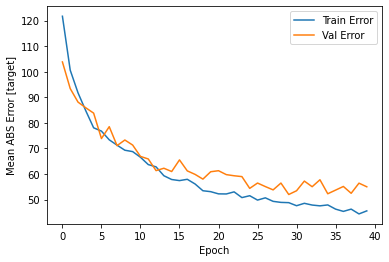

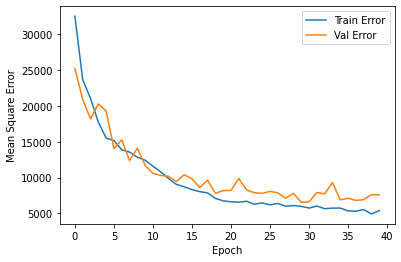

In [ ]:
dnn_bike_model = build_and_compile_model(normalizer)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

history = dnn_bike_model.fit(train_features, train_labels, epochs = Epochs, validation_split = 0.2,
                         verbose = 0, callbacks = [early_stop, PrintDot()])

plot_history(history)

In [ ]:
loss, mae, mse = dnn_bike_model.evaluate(test_features, test_labels, verbose = 0)

print(f"Testing set Mean Absolute Error: {mae} bikes")

Testing set Mean Absolute Error: 55.163856506347656 bikes


(-47.300000000000004, 1015.3, -35.232940721511845, 789.446871805191)

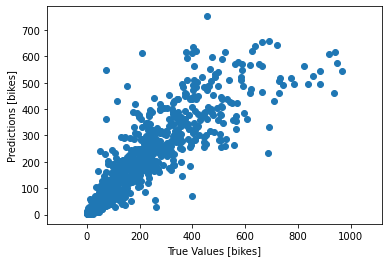

In [ ]:
test_predictions = dnn_bike_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [bikes]")
plt.ylabel("Predictions [bikes]")
plt.xlim([0,test_labels.max()])
plt.ylim([0,test_predictions.max()])
plt.axis('equal')

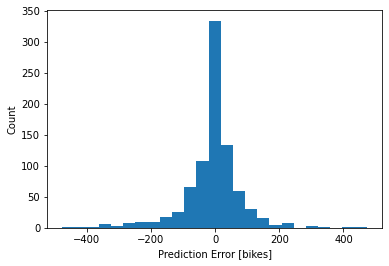

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [bikes]")
_=plt.ylabel("Count")

**Hourly Overall Model**

In [ ]:
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
bikes["month"] = bikes["dteday"].str.split("/").str.get(0)
bikes["month"] = pd.to_numeric(bikes["month"])
bikes.dteday = pd.to_datetime(bikes.dteday)
bikes["target"] = bikes["casual"] + bikes["registered"]

bike = bikes.drop(["holiday","dteday", "feels_like_c", "casual", "registered"], axis = 1).copy()

train_dataset = bike.sample(frac=0.8, random_state=42)
test_dataset = bike.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

def build_and_compile_model(norm):
  model = keras.Sequential([norm,
                            layers.Dense(512, activation = "relu"),#, kernel_regularizer = regularizers.l2(0.0001)),
                            layers.Dense(512, activation = "relu"),#, kernel_regularizer = regularizers.l2(0.0001)),
                            layers.Dense(1)])
  model.compile(loss = tf.keras.losses.Huber(delta = 1), optimizer = tf.optimizers.Adam(learning_rate = 0.01), metrics = ['mae', 'mse'])
  return model

dnn_bike_model = build_and_compile_model(normalizer)
dnn_bike_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 267,794
Trainable params: 267,777
Non-trainable params: 17
_________________________________________________________________


In [ ]:
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print("")
    print(".", end = "")

Epochs = 100

history = dnn_bike_model.fit(
    train_features, train_labels, validation_split = 0.2,
    epochs = Epochs, verbose = 0, callbacks = [PrintDot()]
)


....................................................................................................

In [ ]:
loss, mae, mse = dnn_bike_model.evaluate(test_features, test_labels, verbose = 0)

print(f"Testing set Mean Absolute Error: {mae} bikes")

Testing set Mean Absolute Error: 45.95296859741211 bikes


(-47.75, 1024.75, -40.28609257936478, 860.0683923363686)

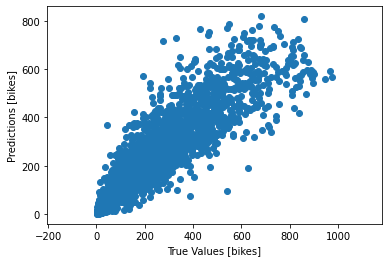

In [ ]:
test_predictions = dnn_bike_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [bikes]")
plt.ylabel("Predictions [bikes]")
plt.xlim([0,test_labels.max()])
plt.ylim([0,test_predictions.max()])
plt.axis('equal')

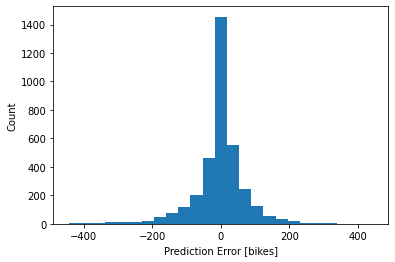

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [bikes]")
_=plt.ylabel("Count")

In [ ]:
bike1 = bike.drop(["target"], axis = 1).copy()

In [ ]:
y_pred = dnn_bike_model.predict(bike1)
bike1["predicted"] = np.round(y_pred, 0)
bike1["predicted"] = bike1["predicted"].astype(int)


bike1[["season", "month", "hr", "workingday", "weathersit", "windspeed", "hum", "temp_c", "predicted"]].head(2)

season  month  hr  workingday  ...  windspeed   hum  temp_c  predicted
0       1      1   0           0  ...          0  0.81    3.28         37
1       1      1   1           0  ...          0  0.80    2.34         29

[2 rows x 9 columns]

In [ ]:
all_mer = pd.merge(bikes, bike1["predicted"], left_index = True, right_index = True)
all_mer["year"] = all_mer["dteday"].str.split("/").str.get(2).str.strip()
all_mer["year"] = all_mer["year"].astype("int")
all_mer["target"] = all_mer["casual"] + all_mer["registered"]
all_mer.head(2)


dteday  season  hr  holiday  ...  registered  predicted  year  target
0  1/1/11       1   0        0  ...          13         37    11      16
1  1/1/11       1   1        0  ...          32         29    11      40

[2 rows x 15 columns]

In [ ]:
bikes_date = bikes[["dteday"]]
date_predict_merger = pd.merge(bikes_date, bike1, left_index = True, right_index = True)
date_predict_merger.head(2)

dteday  season  hr  workingday  ...  windspeed  temp_c  month  predicted
0  1/1/11       1   0           0  ...          0    3.28      1         37
1  1/1/11       1   1           0  ...          0    2.34      1         29

[2 rows x 10 columns]

(-47.800000000000004, 1025.8, -51.6, 907.6)

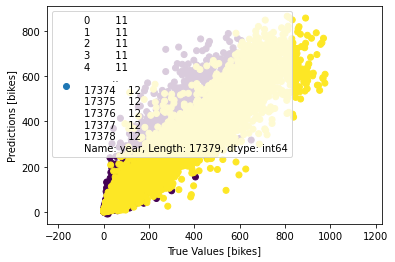

In [ ]:
plt.scatter(all_mer["target"], all_mer["predicted"], c = all_mer.year, label = all_mer["year"])
plt.xlabel("True Values [bikes]")
plt.ylabel("Predictions [bikes]")
plt.legend()
#plt.xlim([0,test_labels.max()])
#plt.ylim([0)
plt.axis('equal')

In [ ]:
import altair as alt
alt.data_transformers.disable_max_rows()

alt.Chart(all_mer).mark_circle().encode(
    alt.X("predicted"),
    alt.Y("target"),
    alt.Color("year")
).properties(
    width = 400, height = 400, title = "Prediction trend"
)

alt.Chart(...)

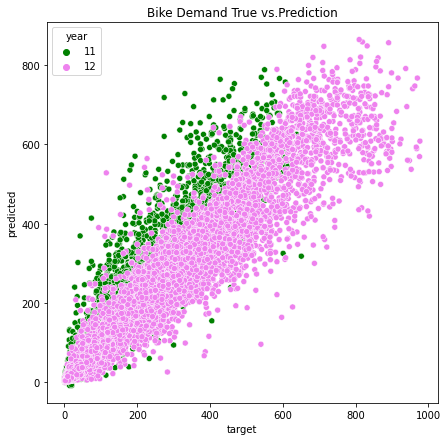

In [ ]:
import seaborn as sns
sns.scatterplot(data = all_mer, x = 'target', y = 'predicted',  hue='year', palette = ["g", "violet"])
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.title("Bike Demand True vs.Prediction")
plt.show()

In [ ]:
total = all_mer.groupby("dteday").target.sum()
predict = all_mer.groupby("dteday").predicted.sum()
a_day_prediction = pd.merge(total, predict, how = "left", left_on = "dteday", right_on = "dteday")
a_day_prediction["error_size"] =  a_day_prediction["predicted"] - a_day_prediction["target"]
a_day_prediction[313:318]

target  predicted  error_size
dteday                                   
2011-11-10    2933       3288         355
2011-11-11    3368       2994        -374
2011-11-12    4067       4122          55
2011-11-13    3717       4027         310
2011-11-14    4486       4863         377

In [ ]:
average_error_size = sum(abs(a_day_prediction["error_size"]))/len(a_day_prediction)
average_error_size

626.1313269493844

In [ ]:
max_error = abs(a_day_prediction["error_size"]).max()
max_error

2633

In [ ]:
min_error = abs(a_day_prediction["error_size"]).min()
min_error

5

Predicting a day bike demand

In [ ]:
a_day = pd.DataFrame({"season":[1]*24, 
                      "month":[1]*24,
                      "hr":[0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                      "workingday":[0]*24,
                      "weathersit":[1,1,1,1,1,2,3,2,1,1,1,1,2,3,3,3,2,1,1,1,1,1,1,1],
                      "windspeed":[0,0,0,15,15,15,14,14,14,13,13,17,17,17,17,18,20,13,13,13,13,13,12,9],
                      "hum":[0.81]*24,
                      "temp_c":[3, 4, 4, 5, 6, 6, 7, 7, 8, 8, 8, 9, 10,12,13,14,15,14,13,12,10,12,8,5]})

p = dnn_bike_model.predict(a_day)
a_day["predict"] = np.round(p, 0).astype(int)
aa = sum(a_day.predict)
print(f"A day bike demand: {aa}")

A day bike demand: 23293


**Rachelle Ceron**

In [ ]:
bikes = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv")
bikes.head()

In [ ]:
bikes['total'] = bikes['casual'] + bikes['registered']
bikes["month"] = bikes["dteday"].str.split("/").str.get(0)
bikes["month"] = pd.to_numeric(bikes["month"])

In [ ]:
bikes = bikes[bikes['season'] == 1]
bikes = bikes.drop(['dteday', 'casual', 'registered', 'hum', 'season'], axis = 1)

In [ ]:
train_dataset = bikes.sample(frac=0.8, random_state = 0)
test_dataset = bikes.drop(train_dataset.index)

In [ ]:
sns.pairplot(train_dataset[['hr','holiday','workingday','weathersit', 'windspeed', 'temp_c', 'feels_like_c', 'month', 'total']], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop('total')
train_stats = train_stats.transpose()
train_stats

In [ ]:
train_labels = train_dataset.pop('total')
test_labels = test_dataset.pop('total')

In [ ]:
def norm(x):
  return ( x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
  model = keras.Sequential([
            layers.Dense(120, activation = tf.nn.tanh, input_shape = [len(train_dataset.keys())]),
            layers.Dense(120, activation = tf.nn.tanh),
            layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam(learning_rate=0.01)

  model.compile(loss = tf.keras.losses.Huber(delta = 1), 
                      optimizer = optimizer,
                      metrics = ['mae', 'mse'])

  return model

In [ ]:
model = build_model()

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Total]')
  plt.plot(hist['epoch'], hist['mae'],
           label = 'Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,30000])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Sqaure Error [$Total^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label = 'Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,30000])

plot_history(history)

In [ ]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS, 
                    validation_split = 0.2, verbose = 0, callbacks = [early_stop, PrintDot()])
plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 0)
print('Testing set Mean Abs Error: {:5.2f} Total'.format(mae))

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Total]')
plt.ylabel('Predictions [Total]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_= plt.plot([-1, 25], [-1,25])

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Total]")
_=plt.ylabel("Count")

***Season 2***

In [ ]:
bikesTwo = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv")
bikesTwo.head()

In [ ]:
bikesTwo['total'] = bikesTwo['casual'] + bikesTwo['registered']

In [ ]:
bikesTwo["month"] = bikesTwo["dteday"].str.split("/").str.get(0)
bikesTwo["month"] = pd.to_numeric(bikesTwo["month"])

In [ ]:
bikesTwo = bikesTwo[bikesTwo['season'] == 2]
bikesTwo = bikesTwo.drop(['dteday', 'casual', 'registered', 'hum', 'season'], axis = 1)

In [ ]:
train_datasetTwo = bikesTwo.sample(frac=0.8, random_state = 0)
test_datasetTwo = bikesTwo.drop(train_datasetTwo.index)

In [ ]:
sns.pairplot(train_datasetTwo[['hr','holiday','workingday','weathersit', 'windspeed', 'temp_c', 'feels_like_c', 'month', 'total']], diag_kind="kde")

In [ ]:
train_statsTwo = train_datasetTwo.describe()
train_statsTwo.pop('total')
train_statsTwo = train_statsTwo.transpose()
train_statsTwo

In [ ]:
train_labelsTwo = train_datasetTwo.pop('total')
test_labelsTwo = test_datasetTwo.pop('total')

In [ ]:
def normTwo(x):
  return ( x - train_statsTwo['mean']) / train_statsTwo['std']
normed_train_dataTwo = normTwo(train_datasetTwo)
normed_test_dataTwo = normTwo(test_datasetTwo)

In [ ]:
def build_modelTwo():
  model = keras.Sequential([
            layers.Dense(100, activation = tf.nn.relu, input_shape = [len(train_datasetTwo.keys())]),
            layers.Dense(100, activation = tf.nn.relu),
            layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam(learning_rate=0.01)

  model.compile(loss = 'mse', 
               optimizer = optimizer,
               metrics = ['mae', 'mse'])
  
  return model

In [ ]:
modelTwo = build_modelTwo()

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20)

historyTwo = modelTwo.fit(normed_train_dataTwo, train_labelsTwo, epochs = EPOCHS, 
                    validation_split = 0.2, verbose = 0, callbacks = [early_stop, PrintDot()])
plot_history(historyTwo)

In [ ]:
lossTwo, maeTwo, mseTwo = modelTwo.evaluate(normed_test_dataTwo, test_labelsTwo, verbose = 0)
print('Testing set Mean Abs Error: {:5.2f} Total'.format(maeTwo))

In [ ]:
test_predictionsTwo = modelTwo.predict(normed_test_dataTwo).flatten()

plt.scatter(test_labelsTwo, test_predictionsTwo)
plt.xlabel('True Values [Total]')
plt.ylabel('Predictions [Total]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_= plt.plot([-1, 25], [-1,25])

**Drew Burns**

In [ ]:
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [ ]:
bikes["total"] = bikes["casual"] + bikes["registered"]
# Creating the month column
bikes["month"] = bikes["dteday"].str.split("/").str[0].astype(int)
# Getting dummies for season column
bikes = pd.get_dummies(bikes, columns=["season"], drop_first=True)
print(bikes.columns)
bikes = bikes.drop(columns=["dteday", "casual", "registered"])

In [ ]:
# This is just a slightly different way of separating the data into X_train, X_test, etc
train = bikes.sample(frac=0.7, random_state=42)
# train.index returns a list of the indeces taken from the bikes dataset
test = bikes.drop(train.index)
# test = test[test["season_3"] == 1]
#############################
# Rows are now split between train and test. Now we have to separate each into
# features and targets
X_train = train.copy()
X_test = test.copy()

y_train = X_train.pop("total")
y_test = X_test.pop("total")

In [ ]:
def build_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(100, activation='tanh'),
      layers.Dense(100, activation='tanh'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error', optimizer="adam")
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

model = build_model(normalizer)

model.fit(
    X_train, y_train,
    verbose=0, epochs=100)

results = model.evaluate(X_test, y_test, verbose=1)

print(f"Results (mean absolute error): {round(results, 3)}")

In [ ]:
y_pred = model.predict(X_test)
test["predicted"] = np.round(y_pred, 0)
test["predicted"] = test["predicted"].astype(int)


print(test[["hr", "weathersit", "holiday", "hum", "windspeed", "temp_c", "total", "predicted"]])

Temperature seems to really affect the result, even if all the other indicators remain about the same. See index 9.

|    |   hr |   weathersit |   holiday |   hum |   windspeed |   temp_c |   total |   predicted |
|---:|-----:|-------------:|----------:|------:|------------:|---------:|--------:|------------:|
|  1 |    1 |            1 |         0 |  0.8  |           0 |     2.34 |      40 |          31 |
|  2 |    2 |            1 |         0 |  0.8  |           0 |     2.34 |      32 |          22 |
|  6 |    6 |            1 |         0 |  0.8  |           0 |     2.34 |       2 |           8 |
|  7 |    7 |            1 |         0 |  0.86 |           0 |     1.4  |       3 |          26 |
|  9 |    9 |            1 |         0 |  0.76 |           0 |     7.04 |      14 |         160 |
| 11 |   11 |            1 |         0 |  0.81 |          19 |     8.92 |      56 |         145 |
| 13 |   13 |            2 |         0 |  0.72 |          20 |    13.62 |      94 |         168 |
| 16 |   16 |            2 |         0 |  0.82 |          20 |    11.74 |      93 |         140 |
| 18 |   18 |            3 |         0 |  0.88 |          17 |    11.74 |      35 |          83 |
| 21 |   21 |            2 |         0 |  0.87 |          13 |    10.8  |      34 |          70 |

Enter custom rows and predict the totals

In [ ]:

small_df = pd.DataFrame({ 
    "hr": [14, 15, 16],
    "holiday": [1, 1, 1], 
    "workingday": [0, 0, 0], 
    "weathersit": [1, 1, 1],
    "hum": [0.7, 0.71, 0.71],
    "windspeed": [2, 3, 2],
    "temp_c": [15, 16, 18],
    "feels_like_c": [14.5, 15, 15],
    "month": [5, 5, 5],
    "season_2": [1, 1, 1],
    "season_3": [0, 0, 0],
    "season_4": [0, 0, 0],
    "total": [-1, -1, -1]
    })
print(small_df.columns)


small_df_X = small_df.copy()
small_df_y = small_df_X.pop("total")

In [ ]:
small_pred = model.predict(small_df_X)
small_df["predicted"] = np.round(small_pred, 0)
small_df["predicted"] = small_df["predicted"].astype(int)


# Note: I made the total -1 for entries that I made myself.
print(small_df[["hr", "weathersit", "holiday", "hum", "windspeed", "temp_c", "total", "predicted"]])

Summer Model (assigned)

In [ ]:
bikes["total"] = bikes["casual"] + bikes["registered"]
# Creating the month column
bikes["month"] = bikes["dteday"].str.split("/").str[0].astype(int)
print(bikes[bikes["month"] == 1]["total"].sum())
print(bikes[bikes["month"] == 2]["total"].sum())
print(bikes[bikes["month"] == 3]["total"].sum())
print(bikes[bikes["month"] == 4]["total"].sum())
# Getting only summer entries
bikes = bikes[bikes["season"] == 3]
bikes = bikes.drop(columns=["dteday", "casual", "registered", "season"])
print(bikes.head())

Splitting the data b/w training and testing

In [ ]:
# This is just a slightly different way of separating the data into X_train, X_test, etc
train = bikes.sample(frac=0.7, random_state=42)
# train.index returns a list of the indeces taken from the bikes dataset
test = bikes.drop(train.index)
#############################
# Rows are now split between train and test. Now we have to separate each into
# features and targets
X_train = train.copy()
X_test = test.copy()

y_train = X_train.pop("total")
y_test = X_test.pop("total")


Build the model

In [ ]:
def build_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(100, activation="relu"),
      layers.Dense(100, activation="exponential"),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.004,
    name='Adam'
    ))
  return model

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

model = build_model(normalizer)


model.fit(
    X_train, y_train,
    verbose=0, epochs=100)

Results (MAE)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)

print(f"Results (mean absolute error): {round(results, 3)}")

Predictions vs. Actual side-by-side

In [ ]:
y_pred = model.predict(X_test)
test["predicted"] = np.round(y_pred, 0)
test["predicted"] = test["predicted"].astype(int)


print(test[["hr", "weathersit", "holiday", "hum", "windspeed", "temp_c", "total", "predicted"]])